# Network Classification Problem


## Declaring Libraries

In [15]:

#basic libraries
import math
import numpy as np

#pandas dataframe
import pandas as pd


#visualization and plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#sklearn (libraries for Machine Learning)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor #RANDOM FOREST ALGORITHM

#oversampling with imbalanced classes
from imblearn.over_sampling import SMOTE

#time and data related
import time
import datetime
from time import mktime
from datetime import timezone

# Seaborn visualization library
import seaborn as sns




## Data Discovery
### Reading Dataset


In [16]:


#open training dataset
file_handler = open("training2APP.csv", "r") 
df_train= pd.read_csv(file_handler, sep = ";") 
file_handler.close()
instances_train=df_train.shape[0] #count the number of instances in the training set

#open test dataset
file_handler = open("test2APP.csv", "r") 
df_test= pd.read_csv(file_handler, sep = ";") 
instances_test=df_test.shape[0]#count the number of instances in the test set
file_handler.close()

#visualizing the first 10 cases inside this dataset
df_train.head(10)

#showing the number of cases and number of features
print('TRAINING: Number of Features in the dataset:', df_train.shape[1])
print('TRAINING: Number of Cases in the dataset:', df_train.shape[0])

print('TEST: Number of Features in the dataset:', df_test.shape[1])
print('TEST: Number of Cases in the dataset:', df_test.shape[0])

#showing other applications


TRAINING: Number of Features in the dataset: 11
TRAINING: Number of Cases in the dataset: 50742
TEST: Number of Features in the dataset: 11
TEST: Number of Cases in the dataset: 35498


## Data Discovery
### Evidencing class imbalance

TRAINING: Class 0 (Non incident): 50174
TRAINING: Class 1(Incident): 568
TRAINING: Incident Proportion (%):  1.1193882779551456


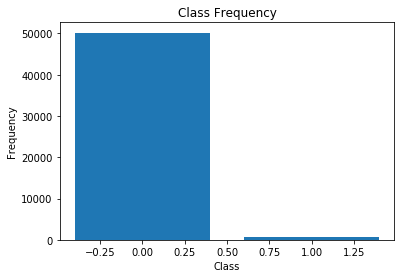

TEST: Class 0 (Non incident): 35292
TEST: Class 1(Incident): 206
TEST: Incident Proportion (%): 0.5803143839089526


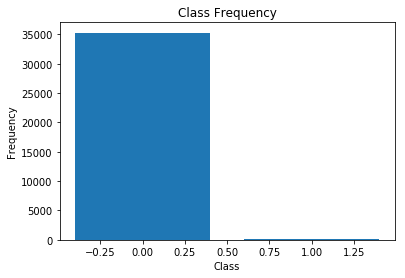

In [17]:

#evidence the imbalance in classes
target_count_training=df_train['Incident_global'].value_counts()

print('TRAINING: Class 0 (Non incident):', target_count_training[0])
print('TRAINING: Class 1(Incident):', target_count_training[1])
print('TRAINING: Incident Proportion (%): ', (target_count_training[1] / instances_train)*100)

unique, counts = np.unique(df_train['Incident_global'].values, return_counts=True)
plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

target_count_test=df_test['Incident_global'].value_counts()

print('TEST: Class 0 (Non incident):', target_count_test[0])
print('TEST: Class 1(Incident):', target_count_test[1])
print('TEST: Incident Proportion (%):', (target_count_test[1] / instances_test)*100)

unique, counts = np.unique(df_test['Incident_global'].values, return_counts=True)
plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()



## Data Discovery
### Parsing the dataset to categorical values

In [18]:

print("BEFORE PARSING TO CATEGORICAL VALUE: ")
print(df_train.iloc[0,:])

app = {'CUSTOMER SERVICES': 1,
         'GEOFIBRE IDENTIFICATION': 2, 
        'IPSITE': 3, 
        'MON CRM': 4, 
         'ORCHESTRATION': 5,
          'PATH IDENTIFICATION': 6,
           'SAVI': 7, 
            'SOFT': 8,
            'SPAS': 9, 
            'SUIVICOM':10}

#training
df_train.Application = [app[item] for item in df_train.Application] 
keys=list(app.keys())
values=list(app.values())
#test
df_test.Application = [app[item] for item in df_test.Application] 
keys=list(app.keys())
values=list(app.values())

print("AFTER PARSING TO CATEGORICAL VALUE: ")
print(df_train.iloc[0,:])

BEFORE PARSING TO CATEGORICAL VALUE: 
Application           CUSTOMER SERVICES
Date_mesure             15/10/2018 8:00
Nb_requetes                        1033
comparaison_prec                    100
Erreur_4xx5xx                        11
Ratio_err                             1
Pages_lentes                          0
Ratio_pages_lentes                    0
Temps_reponse                       291
Ratio_tps_rep                        36
Incident_global                       0
Name: 0, dtype: object
AFTER PARSING TO CATEGORICAL VALUE: 
Application                         1
Date_mesure           15/10/2018 8:00
Nb_requetes                      1033
comparaison_prec                  100
Erreur_4xx5xx                      11
Ratio_err                           1
Pages_lentes                        0
Ratio_pages_lentes                  0
Temps_reponse                     291
Ratio_tps_rep                      36
Incident_global                     0
Name: 0, dtype: object


## Feature Visualization

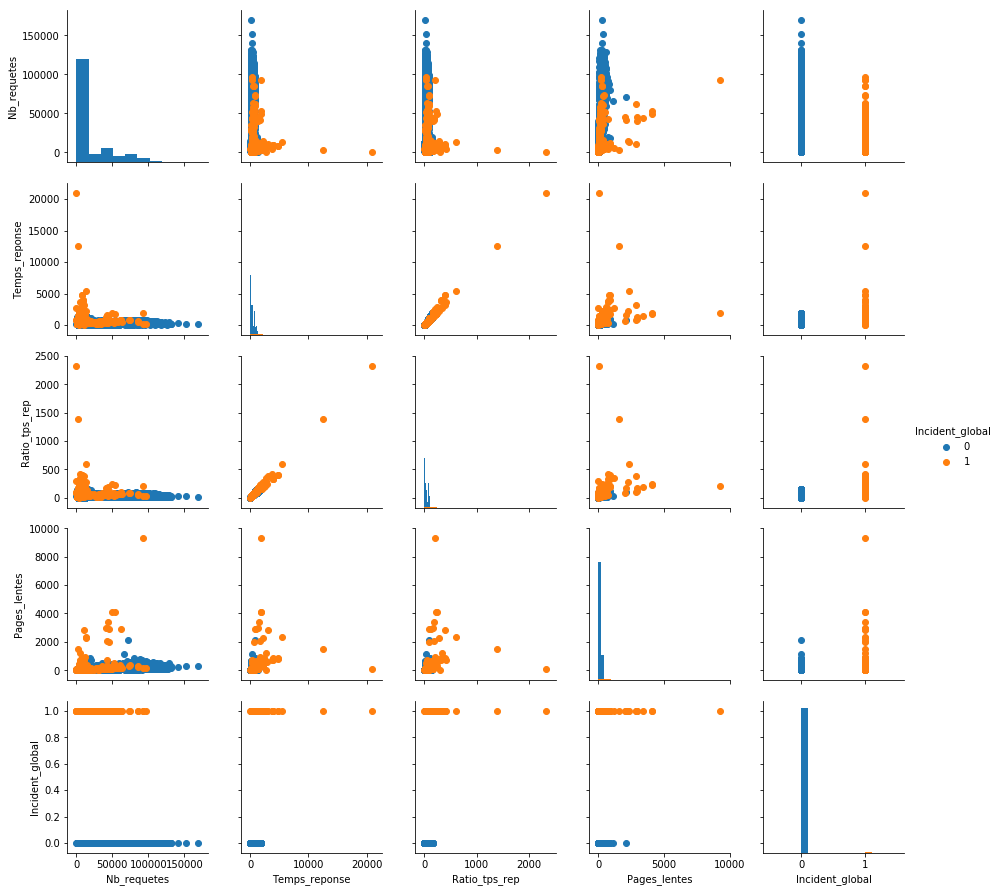

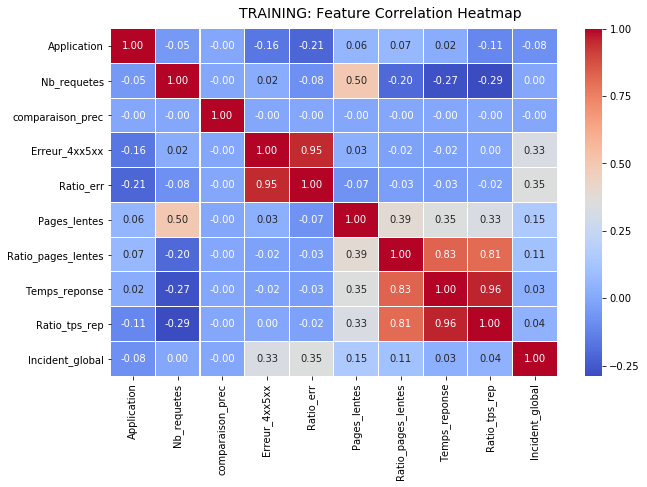

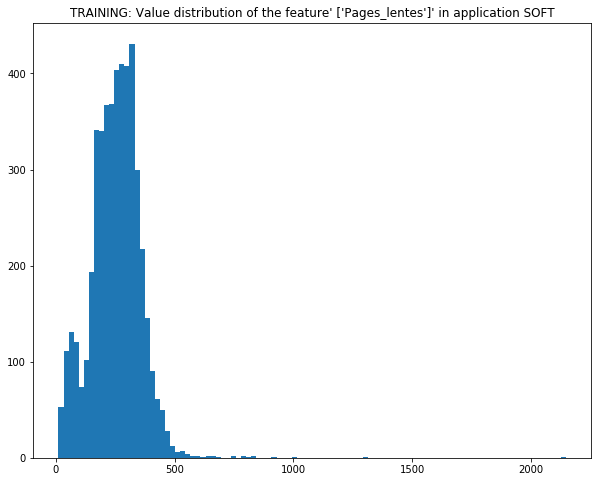

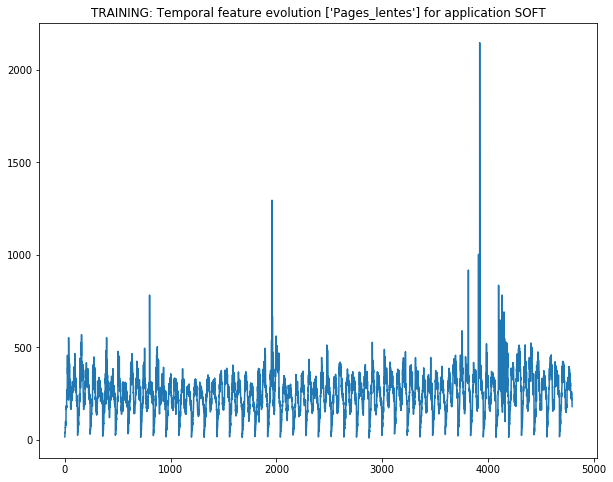

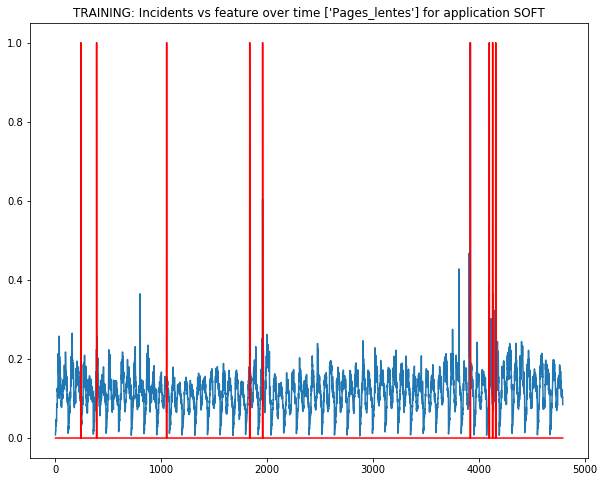

In [19]:
#separate by application
df_trainingapp=df_train.groupby('Application')
df_testapp=df_test.groupby('Application')

features_a = ['Nb_requetes',
            'Temps_reponse',
            'Ratio_tps_rep','Pages_lentes','Incident_global']


#PAIRPLOT REPRESENTATION
g=sns.PairGrid(data=df_test,vars=features_a,hue='Incident_global')
g.map_offdiag(plt.scatter)
g.map_diag(plt.hist)
g.add_legend();
plt.show()


#CORRELATION
f, ax = plt.subplots(figsize=(10, 6))
corr =df_train.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('TRAINING: Feature Correlation Heatmap', fontsize=14)


features_a=['Nb_requetes','Erreur_4xx5xx','Ratio_err','Temps_reponse','Pages_lentes','Incident_global']

df_app_i_train = df_trainingapp.get_group(application).loc[:,features_a] #get the application i and the feature j
df_app_i_test = df_testapp.get_group(application).loc[:,features_a]
    
feature=['Pages_lentes']
application=8
#Separating out the predictors
X_train = df_app_i_train.loc[:, feature].values #without incident
X_test = df_app_i_test.loc[:, feature].values #without incident
    
#Separating out the target
y_train = df_app_i_train.loc[:, 'Incident_global'].values
y_test = df_app_i_test.loc[:, 'Incident_global'].values

#HISTOGRAM REPRESENTATION PER FEATURE
plt.figure(figsize=(10,8))
plt.hist(X_train,density=False, bins=100)
plt.title("TRAINING: Value distribution of the feature' " + str(feature) + "' in application " + str(keys[values.index(application)]))

#TEMPORAL EVOLUTION OF SOME FEATURE
#representation of the features values over time vs incident occurrences
plt.figure(figsize=(10,8))
plt.plot(X_train) #represent feature values (normalized) over the incidents
plt.title("TRAINING: Temporal feature evolution " + str(feature) + " for application " + str(keys[values.index(application)]))
plt.show()

#TRAINING
plt.figure(figsize=(10,8))
plt.plot(X_train/np.max(X_train)) #represent feature values (normalized) over the incidents
plt.plot(y_train,'r') #represent the feature values along with incient values for each application
plt.title("TRAINING: Incidents vs feature over time " + str(feature) + " for application " + str(keys[values.index(application)]))
plt.show()
    

## Data Preprocessing
### Decomposing time feature

In [14]:

print("BEFORE DECOMPOSING TEMPORAL INFORMATION: ")
print(df_train.iloc[0,:])
#train
df_train['day_of_week']=0
df_train['month_of_the_year']=0
df_train['week_number']=0
df_train['region_hour_of_day']=0
df_train['time_of_day']=0
df_train['season']=0

Weekday= lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).weekday()
Month= lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).month
Strftime= lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).strftime('%V')

df_train['day_of_week']=df_train['Date_mesure'].map(Weekday)
df_train['month_of_the_year']=df_train['Date_mesure'].map(Month)
df_train['season']=df_train['Date_mesure'].map(Strftime)

seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).month-1)]
df_train['season']=df_train['Date_mesure'].map(season)

# sleep: 12-5, 6-9: breakfast, 10-14: lunch, 14-17: dinner prep, 17-21: dinner, 21-23: deserts!
hours_of_day = [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5 ]
region_hour_of_day = lambda x: hours_of_day[datetime.datetime.strptime(x, "%d/%m/%Y %H:%M").hour]
hour_of_day = lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M").hour
minute_of_day = lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M").minute

df_train['region_hour_of_day']=df_train['Date_mesure'].map(hour_of_day)  
df_train['time_of_day']=df_train['Date_mesure'].map(minute_of_day) + 60*(df_train['Date_mesure'].map(hour_of_day))

#test
df_test['day_of_week']=0
df_test['month_of_the_year']=0
df_test['week_number']=0
df_test['region_hour_of_day']=0
df_test['time_of_day']=0
df_test['season']=0

Weekday= lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).weekday()
Month= lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).month
Strftime= lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).strftime('%V')

df_test['day_of_week']=df_test['Date_mesure'].map(Weekday)
df_test['month_of_the_year']=df_test['Date_mesure'].map(Month)
df_test['season']=df_test['Date_mesure'].map(Strftime)

seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.datetime.strptime(x, "%d/%m/%Y %H:%M" ).month-1)]
df_test['season']=df_test['Date_mesure'].map(season)

# sleep: 12-5, 6-9: breakfast, 10-14: lunch, 14-17: dinner prep, 17-21: dinner, 21-23: deserts!
hours_of_day = [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5 ]
region_hour_of_day = lambda x: hours_of_day[datetime.datetime.strptime(x, "%d/%m/%Y %H:%M").hour]
hour_of_day = lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M").hour
minute_of_day = lambda x: datetime.datetime.strptime(x, "%d/%m/%Y %H:%M").minute

df_test['region_hour_of_day']=df_test['Date_mesure'].map(hour_of_day)  
df_test['time_of_day']=df_test['Date_mesure'].map(minute_of_day) + 60*(df_test['Date_mesure'].map(hour_of_day))

print("AFTER DECOMPOSING TEMPORAL INFORMATION: ")
print(df_train.iloc[0,:])

BEFORE DECOMPOSING TEMPORAL INFORMATION: 
Application                         1
Date_mesure           15/10/2018 8:00
Nb_requetes                      1033
comparaison_prec                  100
Erreur_4xx5xx                      11
Ratio_err                           1
Pages_lentes                        0
Ratio_pages_lentes                  0
Temps_reponse                     291
Ratio_tps_rep                      36
Incident_global                     0
Name: 0, dtype: object
AFTER DECOMPOSING TEMPORAL INFORMATION: 
Application                         1
Date_mesure           15/10/2018 8:00
Nb_requetes                      1033
comparaison_prec                  100
Erreur_4xx5xx                      11
Ratio_err                           1
Pages_lentes                        0
Ratio_pages_lentes                  0
Temps_reponse                     291
Ratio_tps_rep                      36
Incident_global                     0
day_of_week                         0
month_of_the_year   

## Data Preparation
### Detecting missing observations in the dataset

In [12]:

features = ['region_hour_of_day','time_of_day','Nb_requetes','Erreur_4xx5xx','Ratio_err',
            'Ratio_pages_lentes','Temps_reponse','Application',
            'comparaison_prec','Ratio_tps_rep','Pages_lentes' ]

training_gaps=0
test_gaps=0

for i in range(1,11): #for each app we cluster to find anomalies 
    df_app_i_train = df_trainingapp.get_group(i).loc[:,features] #get the application i and the feature j
    df_app_i_test = df_testapp.get_group(i).loc[:,features]
    counts_train=5280-df_app_i_train.shape[0]
    counts_test=3600-df_app_i_test.shape[0]
    training_gaps=training_gaps+counts_train
    test_gaps=test_gaps+counts_test
    print("-----------------------------------------------")
    #print(df_app_i_train.shape[0])
    #print(df_app_i_test.shape[0])
    print("TRAINING: Number of Missing observations in application "+str(keys[values.index(i)])+": "+str(counts_train))
    print("TEST: Number of Missing observations in application "+str(keys[values.index(i)])+": "+str(counts_test))

print("-----------------------------------------------")
print("TRAINING: Number of Missing observations in the dataset "+str(training_gaps))
print("TRAINING: Missing data (%) "+str((training_gaps/df_train.shape[0])*100))
print("-----------------------------------------------")
print("TEST: Number of Missing observations in the dataset "+str(test_gaps))
print("TEST: Missing data (%) "+str((test_gaps/df_test.shape[0])*100))

-----------------------------------------------
TRAINING: Number of Missing observations in application CUSTOMER SERVICES: 2
TEST: Number of Missing observations in application CUSTOMER SERVICES: 0
-----------------------------------------------
TRAINING: Number of Missing observations in application GEOFIBRE IDENTIFICATION: 243
TEST: Number of Missing observations in application GEOFIBRE IDENTIFICATION: 1
-----------------------------------------------
TRAINING: Number of Missing observations in application IPSITE: 1
TEST: Number of Missing observations in application IPSITE: 0
-----------------------------------------------
TRAINING: Number of Missing observations in application MON CRM: 240
TEST: Number of Missing observations in application MON CRM: 0
-----------------------------------------------
TRAINING: Number of Missing observations in application ORCHESTRATION: 120
TEST: Number of Missing observations in application ORCHESTRATION: 0
------------------------------------------

C:\Users\dnkx4622\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Data Preprocessing
### Feature engineering: Adding new features based on temporal variation

In [13]:

#COMMENT DIFF
features2=['Nb_requetes','Temps_reponse','comparaison_prec'] #features over which i will compute percentage variation

print("BEFORE ADDING PORCENTAGE VARIATION INFORMATION: ")
print(df_train.iloc[50,:])
#training
df_train10=df_train.loc[:,features2].pct_change(periods=1)
df_train10 = df_train10.mask(np.isinf(df_train10))
df_train10=df_train10.fillna(0)
df_train20=df_train.loc[:,features2].pct_change(periods=5)
df_train20 = df_train20.mask(np.isinf(df_train20))
df_train20=df_train20.fillna(0)
df_train50=df_train.loc[:,features2].pct_change(periods=10)
df_train50 = df_train50.mask(np.isinf(df_train50))
df_train50=df_train50.fillna(0)
df_train100=df_train.loc[:,features2].pct_change(periods=15)
df_train100 = df_train100.mask(np.isinf(df_train100))
df_train100=df_train100.fillna(0)
df_train200=df_train.loc[:,features2].pct_change(periods=20)
df_train200 = df_train200.mask(np.isinf(df_train200))
df_train200=df_train200.fillna(0)
df_train500=df_train.loc[:,features2].pct_change(periods=25)
df_train500 = df_train500.mask(np.isinf(df_train500))
df_train500=df_train500.fillna(0)

#test
df_test10=df_test.loc[:,features2].pct_change(periods=1)
df_test10 = df_test10.mask(np.isinf(df_test10))
df_test10=df_test10.fillna(0)
df_test20=df_test.loc[:,features2].pct_change(periods=5)
df_test20 = df_test20.mask(np.isinf(df_test20))
df_test20=df_test20.fillna(0)
df_test50=df_test.loc[:,features2].pct_change(periods=10)
df_test50 = df_test50.mask(np.isinf(df_test50))
df_test50=df_test50.fillna(0)
df_test100=df_test.loc[:,features2].pct_change(periods=15)
df_test100 = df_test100.mask(np.isinf(df_test100))
df_test100=df_test100.fillna(0)
df_test200=df_test.loc[:,features2].pct_change(periods=20)
df_test200 = df_test200.mask(np.isinf(df_test200))
df_test200=df_test200.fillna(0)
df_test500=df_test.loc[:,features2].pct_change(periods=25)
df_test500 = df_test500.mask(np.isinf(df_test500))
df_test500=df_test500.fillna(0)

df_train10.rename(columns={'Nb_requetes':'NbVar10','Temps_reponse':'TempsVar10',
                        'comparaison_prec':'CompVar10'},inplace=True)
df_test10.rename(columns={'Nb_requetes':'NbVar10','Temps_reponse':'TempsVar10',
                        'comparaison_prec':'CompVar10'},inplace=True)
df_train20.rename(columns={'Nb_requetes':'NbVar20','Temps_reponse':'TempsVar20',
                        'comparaison_prec':'CompVar20'},inplace=True)
df_test20.rename(columns={'Nb_requetes':'NbVar20','Temps_reponse':'TempsVar20',
                        'comparaison_prec':'CompVar20'},inplace=True)
df_train50.rename(columns={'Nb_requetes':'NbVar50','Temps_reponse':'TempsVar50',
                        'comparaison_prec':'CompVar50'},inplace=True)
df_test50.rename(columns={'Nb_requetes':'NbVar50','Temps_reponse':'TempsVar50',
                        'comparaison_prec':'CompVar50'},inplace=True)
df_train100.rename(columns={'Nb_requetes':'NbVar100','Temps_reponse':'TempsVar100',
                        'comparaison_prec':'CompVar100'},inplace=True)
df_test100.rename(columns={'Nb_requetes':'NbVar100','Temps_reponse':'TempsVar100',
                        'comparaison_prec':'CompVar100'},inplace=True)
df_train200.rename(columns={'Nb_requetes':'NbVar200','Temps_reponse':'TempsVar200',
                        'comparaison_prec':'CompVar200'},inplace=True)
df_test200.rename(columns={'Nb_requetes':'NbVar200','Temps_reponse':'TempsVar200',
                        'comparaison_prec':'CompVar200'},inplace=True)
df_train500.rename(columns={'Nb_requetes':'NbVar500','Temps_reponse':'TempsVar500',
                        'comparaison_prec':'CompVar500'},inplace=True)
df_test500.rename(columns={'Nb_requetes':'NbVar500','Temps_reponse':'TempsVar500',
                        'comparaison_prec':'CompVar500'},inplace=True)

# adding the newly computed feature on the dataset
df_train_final=pd.concat([df_train, df_train10, df_train20, df_train50, df_train100, df_train200, df_train500],axis=1,sort=False)
df_test_final=pd.concat([df_test, df_test10, df_test20, df_test50, df_test100, df_test200, df_test500],axis=1,sort=False)

df_train_final.drop(columns=['Date_mesure','Incident_global'],inplace=True)
df_test_final.drop(columns=['Date_mesure','Incident_global'],inplace=True)


print("-----------------------------------------------")
print("AFTER ADDING PORCENTAGE VARIATION INFORMATION: ")
print(df_train_final.iloc[50,:])



BEFORE ADDING PORCENTAGE VARIATION INFORMATION: 
Application                          1
Date_mesure           15/10/2018 12:10
Nb_requetes                       3558
comparaison_prec                   101
Erreur_4xx5xx                       41
Ratio_err                            1
Pages_lentes                         1
Ratio_pages_lentes                   0
Temps_reponse                      294
Ratio_tps_rep                       36
Incident_global                      0
Name: 50, dtype: object
-----------------------------------------------
AFTER ADDING PORCENTAGE VARIATION INFORMATION: 
Application              1.000000
Nb_requetes           3558.000000
comparaison_prec       101.000000
Erreur_4xx5xx           41.000000
Ratio_err                1.000000
Pages_lentes             1.000000
Ratio_pages_lentes       0.000000
Temps_reponse          294.000000
Ratio_tps_rep           36.000000
NbVar10                  0.012521
TempsVar10              -0.092593
CompVar10                0.0

## Training Phase
### Choosing the ML model: Random Forest

In [ ]:

features = ['region_hour_of_day','time_of_day','Nb_requetes','Erreur_4xx5xx','Ratio_err',
            'Ratio_pages_lentes','Temps_reponse','Application',
            'comparaison_prec','Ratio_tps_rep','Pages_lentes',
            'NbVar10','NbVar50','NbVar100','NbVar200','NbVar500',
            'CompVar10','TempsVar10','TempsVar20','TempsVar50','TempsVar100','TempsVar200','TempsVar500' ]

df_train.shape

n_features=len(features)
# Separating out the predictors
X_train = df_train_final.loc[:, features].values
X_test = df_test_final.loc[:, features].values

#separating out the target
y_test= df_test.loc[:,['Incident_global']].values
y_train= df_train.loc[:,['Incident_global']].values

#algorithm choice: Random Forest
model0=RandomForestClassifier()

model1= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=n_features, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=44, verbose=0,
            warm_start=False)


model2 = RandomForestClassifier(bootstrap=True, class_weight={0:1,1:5}, criterion='gini',
            max_depth=6, max_features=n_features, max_leaf_nodes=23,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=44, verbose=0,
            warm_start=False)


## Random Forest Fundamentals
- Use of __multiple decision trees__ --> n_estimators
- Each decision tree in the considers a random subset of features (m<M) and only has access to a random sampling set of the training data points. 
- A voting mechanism is used to choose the most voted class by the trees 
- One key advantage is that is less prone to overfitting due to voting mechanism (average)
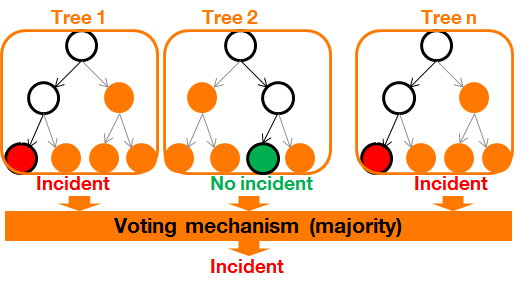



## Decision tree example 
To give a clear example of what a Decision Tree is:
- Each decision tree is used to make decisions based on questions on the features composed of nodes and arcs
- nodes are labelled  with the input features
- the arcs from the nodes represent values ranges for the features
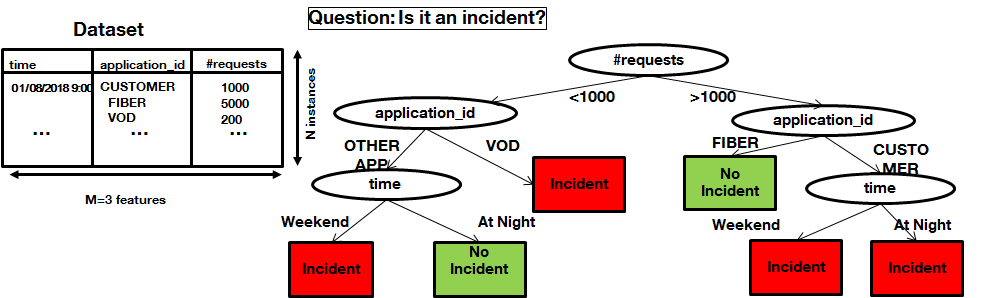


## Training Phase
### Fitting the trained model

In [30]:
#fitting the trained model
model2.fit(X_train, y_train)

C:\Users\dnkx4622\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 5},
            criterion='gini', max_depth=6, max_features=23,
            max_leaf_nodes=23, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=44,
            verbose=0, warm_start=False)

## Training Phase
### Key hyperparameters to better fine-tune a Random Forest model
- the number of decisions trees (n) a.k.a __n_estimators__. The more the better the learning

- __max_depth__ of each tree represents the depth of each tree. The more depth more data it captures and more splits

- __max_features__ : the number of features to consider to split.

- __min_samples_split__: the minimum number of samples required to split an internal node

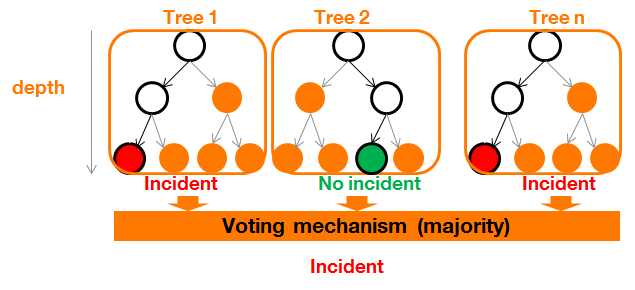

## Training Phase
### Feature Importance in the ML model generated

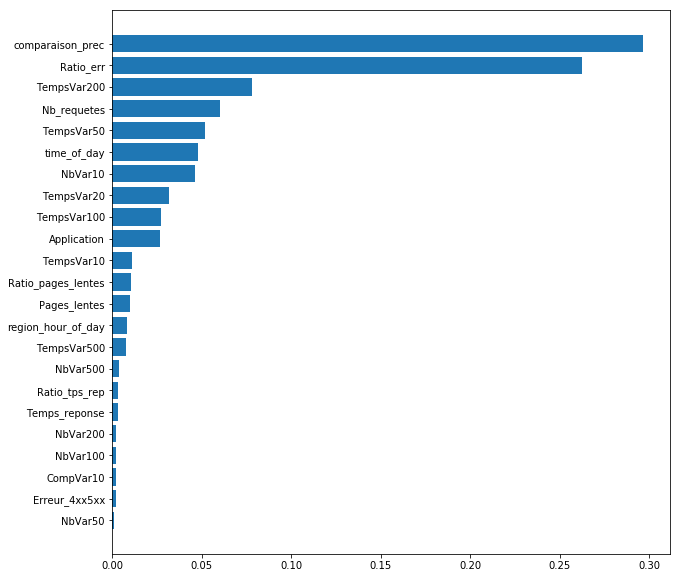

In [28]:
#FEATURE IMPORTANCE
imp=model2.feature_importances_ 
names=features
plt.figure(figsize=(10,10))
imp,names=zip(*sorted(zip(imp,names)))
plt.barh(range(len(names)),imp,align = 'center')
plt.yticks(range(len(names)),names)
plt.show()


## Test Phase
### Incident prediction over the test set

In [14]:
TEST PHASE
#model prediciton on the test set
y_pred=model2.predict(X_test)


SyntaxError: invalid syntax (<ipython-input-14-cae6184e2ac3>, line 1)

## Test Phase
### ML model Evaluation and performance metrics


Score: 0.9974364752943827
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35292
           1       0.74      0.87      0.80       206

   micro avg       1.00      1.00      1.00     35498
   macro avg       0.87      0.93      0.90     35498
weighted avg       1.00      1.00      1.00     35498



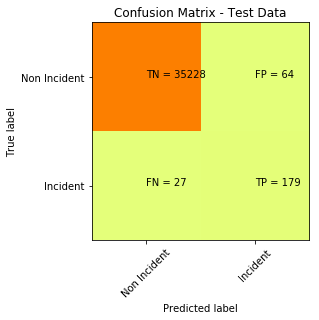

PRECISION: 0.7366255144032922
RECALL: 0.8689320388349514
F-SCORE: 0.7973273942093541
MISSCLASSIFICATION RATE (%): 0.2563524705617218
AUC: 0.9335592983475448


In [29]:

#model evaluation based on confusion matrix
print("Score:", accuracy_score(y_test, y_pred, normalize=True))
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Non Incident','Incident']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

plt.show()

K=df_test_final.shape[0]

TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

#METRICS BASED ON CONFUSION MATRIX
precision=TP/(TP+FP)
recall=TP/(TP+FN)
fscore=2*precision*recall/(precision + recall)
print("PRECISION: "+str(precision))
print("RECALL: "+str(recall))
print("F-SCORE: "+str(fscore))
print("MISSCLASSIFICATION RATE (%): "+str(100*(FN+FP)/K))
fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC: "+str(metrics.auc(fpr, tpr)))



## Comparison of default RF model with fine-tuned RF models
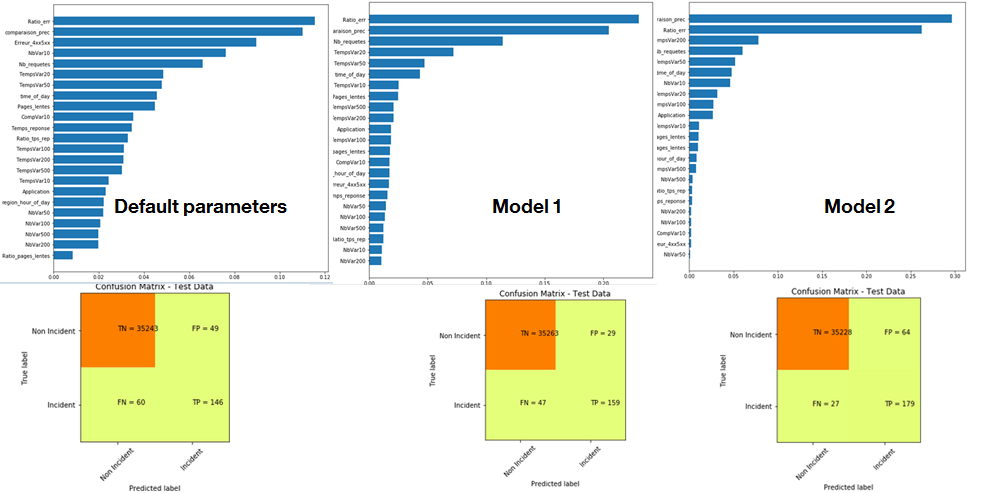